In [1]:
# default_exp scenery

# Scenery Style Dither Effect

<br>

### Imports

In [2]:
import pandas as pd
import numpy as np

from scipy import ndimage
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import FEAutils as hlp

In [3]:
from IPython import display

<br>

### Image Processing

We'll start by just displaying the raw `.jpg` image

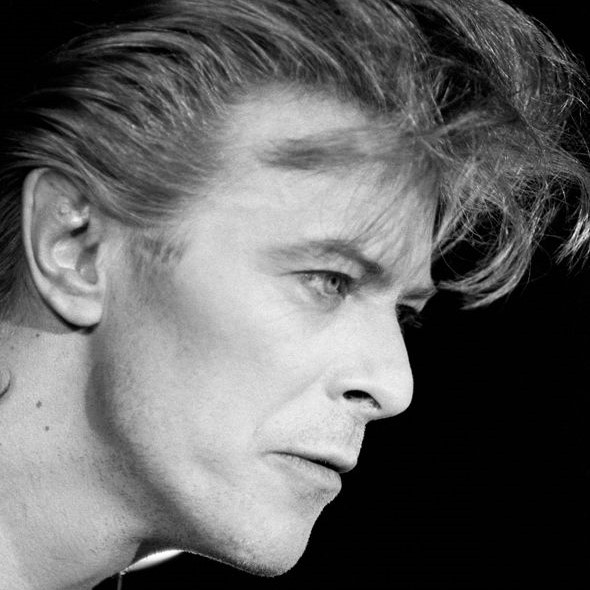

In [4]:
bowie_fp = '../img/scenery/bowie.jpg'

display.Image(bowie_fp, width=250)

<br>

We can load this in and extract the pixel values as a numpy array

In [5]:
raw_img = Image.open(bowie_fp)

img_matrix = np.asarray(raw_img.getdata())

img_matrix.shape

(348100, 3)

<br>

However the positions of the pixels are expressed within a 1d matrix, with another dimension for the rgb channels. We'll express the positions in terms of their x and y locations, this can be achieved using `reshape`.

In [6]:
img_cube = img_matrix.reshape(raw_img.size[1], raw_img.size[0], 3)

img_cube.shape

(590, 590, 3)

<br>

We'll combine these steps into a single function and also add in some checks as well

In [7]:
#exports
def load_img_data(img_fp):
    raw_img = Image.open(img_fp)
    img_matrix = np.asarray(raw_img.getdata())

    expected_num_dims = 2
    assert len(img_matrix.shape) == expected_num_dims, f'The image matrix should have {expected_num_dims} dimensions but yours has {len(img_matrix.shape)}'

    num_colour_dims = img_matrix.shape[-1]
    assert num_colour_dims == 3, f'There should be 3 colour dimensions but instead there are {num_colour_dims}'
    img_cube = img_matrix.reshape(raw_img.size[1], raw_img.size[0], num_colour_dims)
    
    return img_cube

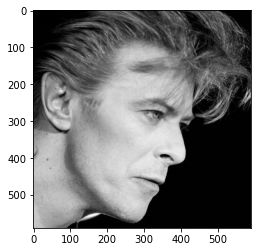

In [8]:
img_cube = load_img_data(bowie_fp)
plt.imshow(img_cube)

<br>

We'll now convert the rgb image to greyscale

In [30]:
#exports
rgb_to_bw = lambda img_rgb: np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140])

The new image dimensions are: (590, 590)


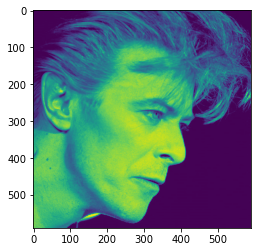

In [31]:
img_bw = rgb_to_bw(img_cube)

print(f'The new image dimensions are: {img_bw.shape}')

plt.imshow(img_bw)

<br>

We've converted the image to black and white but when plotted its gone green, what's happened?! 

By default, when an array is passed to `imshow` and the third dimension has a length of three, `matplotlib` will produce an rgb image - which in the case of our example image was already in black and white over those 3 bands. When we then created a 2-dimensional image array containing only the pixel intensity, `imshow` uses a colormap that so happens to default to `viridis` which leaves us with the green and purple representation. To go back to our black and white image we just specify the `cmap` as `gray`.

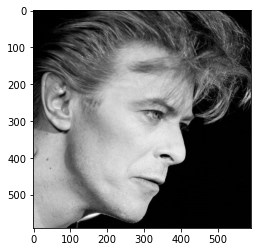

In [11]:
plt.imshow(img_bw, cmap='gray')

<br>

We need to change the resolution of the image in order for our dots to be more clearly visible. To do this we'll use the `ndimage` function from `scipy`.

N.b. to change things up a bit we've used a `seaborn` `heatmap` to visualise the image, this is helpful as it also gives us a labelled colorbar automatically

In [12]:
#exports
def change_resolution(data, num_rows=64, num_cols=64):
    x_zoom = num_rows/data.shape[0]
    y_zoom = num_cols/data.shape[1]
        
    resized_data = ndimage.zoom(data, [x_zoom, y_zoom])
    
    return resized_data

<AxesSubplot:>

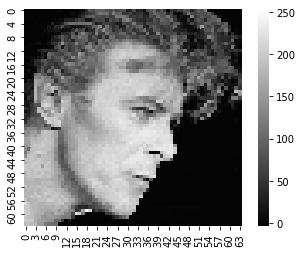

In [13]:
img_resized = change_resolution(img_bw, 64, 64)

sns.heatmap(img_resized, cmap='gray', square=True)

<br>

We'll now scale the pixel intensity between 0 - 1, additionally including thresholds to clip the minimum and maximum values

In [14]:
#exports
def scale_pixel_intensity(img_bw, min_threshold_frac=0.25, max_threshold_frac=0.95):
    img_pass1_intensity_range = img_bw.max() - img_bw.min()
    img_scaled_pass1 = (img_bw - img_bw.min())/img_pass1_intensity_range
    
    img_clipped = img_scaled_pass1.clip(min_threshold_frac, max_threshold_frac) - min_threshold_frac
    
    img_pass2_intensity_range = img_clipped.max() - img_clipped.min()
    img_scaled_pass2 = (img_clipped - img_clipped.min())/img_pass2_intensity_range
    
    return img_scaled_pass2

<AxesSubplot:>

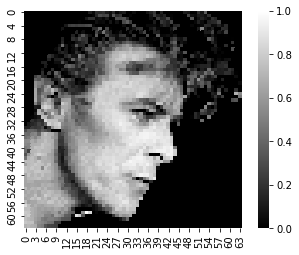

In [15]:
img_scaled = scale_pixel_intensity(img_resized)

sns.heatmap(img_scaled, cmap='gray', square=True)

<br>

We'll quickly visualise the distribution of the scaled pixel intensities

(0.0, 1.0)

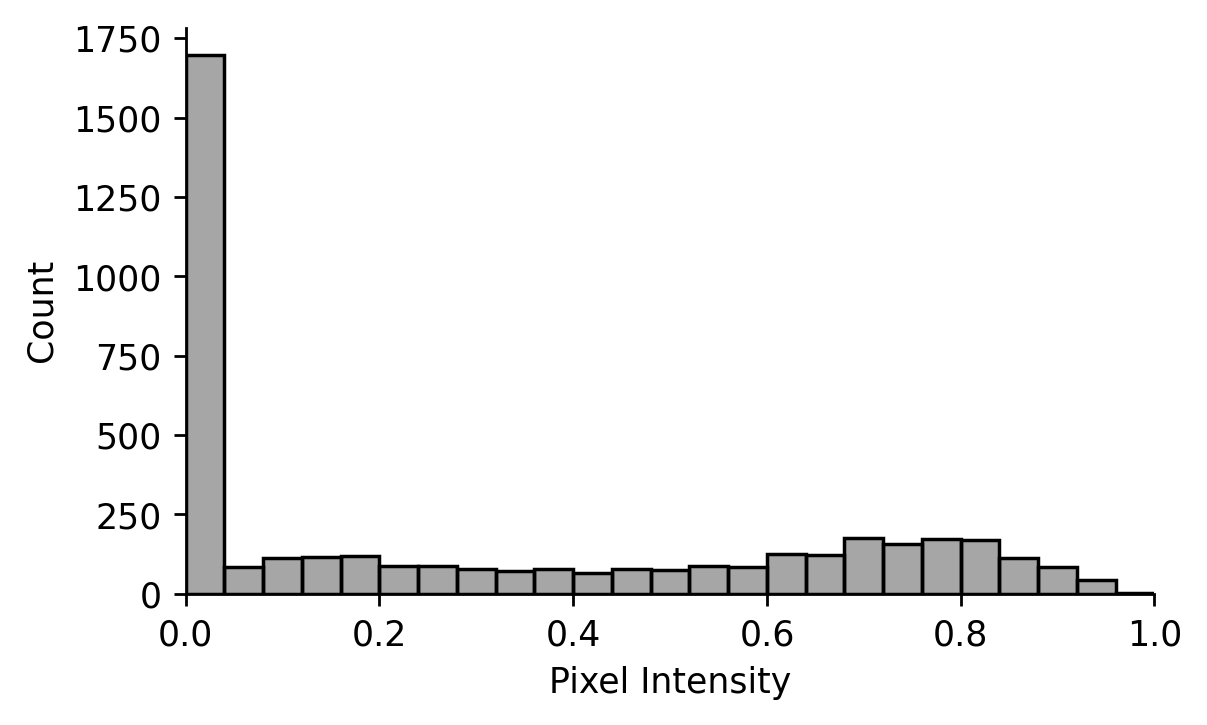

In [16]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=250)

sns.histplot(img_scaled.reshape(-1), color='k', alpha=0.35, bins=25, ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('Pixel Intensity')
ax.set_xlim(0, 1)

<br>

We also need to take the negative of the image as our pixel intensity will become dot size, meaning that we want the previously white areas to have a value of 0 as that means they will remain lighter than the areas with black dots.

In [17]:
#exports
get_img_negative = lambda img: 1-scale_pixel_intensity(img, 0, 1)

<AxesSubplot:>

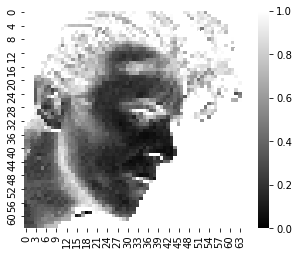

In [18]:
img_neg = get_img_negative(img_scaled)

sns.heatmap(img_neg, cmap='gray', square=True)

<br>

We'll now combine the full processing pipeline into a single function and then time it

In [19]:
#exports
def process_img(img_fp, num_rows=64, num_cols=64, min_threshold_frac=0.25, max_threshold_frac=0.95):
    img_cube = load_img_data(img_fp)
    img_bw = rgb_to_bw(img_cube)
    img_resized = change_resolution(img_bw, num_rows, num_cols)
    img_scaled = scale_pixel_intensity(img_resized, min_threshold_frac, max_threshold_frac)
    img_neg = get_img_negative(img_scaled)
    
    return img_neg

In [20]:
%%timeit

process_img(bowie_fp)

534 ms ± 9.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

### Scenery Dither with Matplotlib

We can create a dataframe with the x/y positions and dot size values

In [26]:
dot_scale_factor = 1.75

df = (pd.DataFrame(img_neg)
      .unstack()
      .reset_index()
      .rename(columns={
          'level_0' : 'x',
          'level_1' : 'y',
          0 : 'dot_size',
      })
      .pipe(lambda df: df.assign(dot_size=df['dot_size']*dot_scale_factor))
     )

df['y'] = df['y'].max() - df['y']

df.head()

,x,y,dot_size
0,0,63,1.75
1,0,62,1.75
2,0,61,1.75
3,0,60,1.75
4,0,59,1.75


<br>

We can then use a `matplotlib` `scatterplot` to produce the desired dithering effect

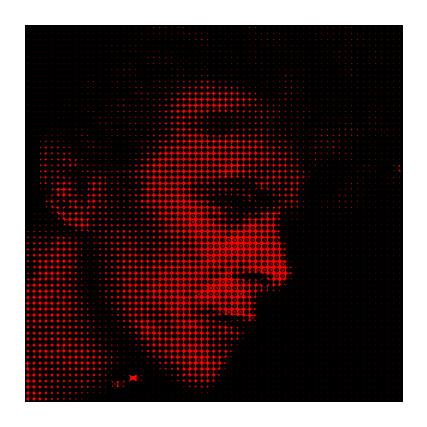

In [29]:
fig, ax = plt.subplots(dpi=250, figsize=(2, 2))

ax.scatter(df['x'], df['y'], s=df['dot_size'], color='k')

ax.set_facecolor('red')
ax.set_aspect('equal')

ax.set_xlim(0, 63)
ax.set_ylim(0, 63)

hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
_ = ax.set_xticks([])
_ = ax.set_yticks([])

<br>

### Scenery Dither with Cairo

In [24]:
# Should output an SVG with dots
# Should separate the vector gen for the dot size and the dot drawing
# Could interpolate between two images and create a GIF of the transition

In [25]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-solar-system.ipynb.
Converted 02-scenery-dither.ipynb.
